In [ ]:
# @title Setup and Imports
# @markdown This notebook performs Correspondence Analysis (CA) on a text corpus from a CSV file.
# @markdown The CSV file is expected to have a column named 'Text' containing the documents.
# @markdown
# @markdown **Steps:**
# @markdown 1.  **Setup:** Install and import necessary libraries, and mount Google Drive.
# @markdown 2.  **Data Loading:** Load the dataset from a CSV file.
# @markdown 3.  **Preprocessing:** Create a document-term matrix from the text data.
# @markdown 4.  **Analysis:** Perform Correspondence Analysis on the matrix.
# @markdown 5.  **Visualization:** Plot the results to visualize relationships between documents and terms.

# Install the 'prince' library for Correspondence Analysis
!pip install prince -q

# Import necessary libraries
import pandas as pd
import numpy as np
import prince
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive to access files
try:
    drive.mount('/content/drive')
except:
    print("Google Drive is already mounted.")

# Set plot style
sns.set_style('whitegrid')
print("Setup complete. Libraries are imported and Google Drive is mounted.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 5.2 MB/s eta 0:00:00
Mounted at /content/drive
Setup complete. Libraries are imported and Google Drive is mounted.


In [ ]:
# @title Load the dataset
# @markdown Specify the path to your CSV file in Google Drive.
# @markdown This file should contain a 'Text' column with your documents.
file_path = '/content/drive/MyDrive/Colab_Data/lemmatized_output.csv'  # @param {type:"string"}

# Load the dataset
try:
    df = pd.read_csv(file_path)
    df['Text'] = df['text_lemmatized']
    # Verify that the 'Text' column exists
    if 'Text' not in df.columns:
        raise ValueError("CSV must have a 'Text' column.")
    print(f"Dataset loaded successfully from {file_path}")
    print(f"Number of documents: {len(df)}")
    print("First 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print(f"File not found at {file_path}. Please check the path and try again.")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset loaded successfully from /content/drive/MyDrive/Colab_Data/lemmatized_output.csv
Number of documents: 634
First 5 rows of the dataset:
                    id                              Grok Vision 2 Prompts  \
0  1824983266878713985  A man with a stern expression, dressed in a fo...   
1  1823179645828944261  A cartoon-style anthropomorphic bird character...   
2  1823780219204890916  A woman wearing a red "TRUMP DACE" cap and a b...   
3  1823793576393965961  A detailed text prompt for generating this ima...   
4  1824950468399038937  A stern-faced middle-aged man with blond hair,...   

                                     text_lemmatized  \
0  man stern expression dress formal black suit r...   
1  cartoon style anthropomorphic bird character e...   
2  woman wear red trump dace cap black face mask ...   
3  detailed text prompt generate image young woma...   
4  stern face middle aged man blond hair wear dar...   

                                                Text  
0 

In [ ]:
# @title Create Document-Term Matrix
# @markdown This cell creates a document-term matrix from the 'Text' column of the dataset.

# Create a CountVectorizer to convert text to a matrix of token counts
vectorizer = CountVectorizer(stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['Text'])

# Convert the matrix to a pandas DataFrame for better readability
doc_term_df = pd.DataFrame(doc_term_matrix.toarray(), columns=vectorizer.get_feature_names_out())

print("Document-term matrix created successfully.")
print(f"Matrix shape: {doc_term_df.shape}")
print("Document-Term Matrix (first 5 rows and 10 columns):")
print(doc_term_df.head().iloc[:, :10])

Document-term matrix created successfully.
Matrix shape: (634, 4872)
Document-Term Matrix (first 5 rows and 10 columns):
   aaron  aarons  abandon  abdomen  ability  aboard  abraham  absence  absent  \
0      0       0        0        0        0       0        0        0       0   
1      0       0        0        0        0       0        0        0       0   
2      0       0        0        0        0       0        0        0       0   
3      0       0        0        0        0       0        0        0       0   
4      0       0        0        0        0       0        0        0       0   

   absolutely  
0           0  
1           0  
2           0  
3           0  
4           0  


In [ ]:
# @title Perform Correspondence Analysis
# @markdown This cell performs Correspondence Analysis on the document-term matrix.

# Initialize CA with 2 components
ca = prince.CA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='scipy', # Changed 'auto' to 'scipy'
    random_state=42
)

# Fit the CA model to the document-term matrix
ca = ca.fit(doc_term_df)

print("Correspondence Analysis complete.")

Correspondence Analysis complete.


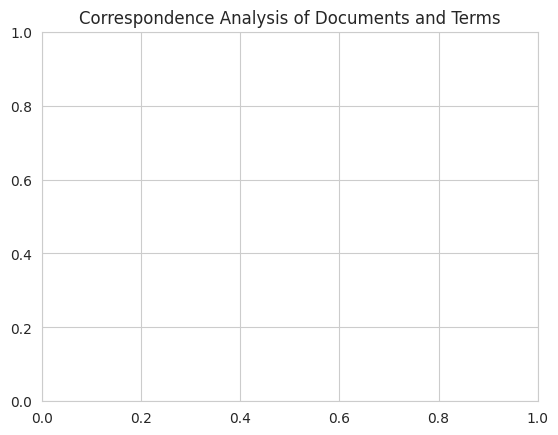

In [ ]:
# @title Visualize the Results with Labels
# @markdown This cell creates a scatter plot to visualize the results of the CA, with labels for the most significant documents and terms.
# @markdown To avoid overlapping labels, the `adjustText` library is used.

# Install adjustText library
!pip install adjustText -q

from adjustText import adjust_text

# Get the coordinates for rows (documents) and columns (terms)
row_coords = ca.row_coordinates(doc_term_df)
col_coords = ca.column_coordinates(doc_term_df)

# --- Select top N labels to display to avoid clutter ---
N_TERMS = 20  # Number of top terms to label
N_DOCS = 20   # Number of top documents to label

# Calculate squared distance from origin for terms
col_coords['dist'] = col_coords[0]**2 + col_coords[1]**2
top_terms = col_coords.nlargest(N_TERMS, 'dist')

# Calculate squared distance from origin for documents
row_coords['dist'] = row_coords[0]**2 + row_coords[1]**2
top_docs = row_coords.nlargest(N_DOCS, 'dist')

# --- Create the plot ---
fig, ax = plt.subplots(figsize=(16, 12))

# Plot all points without labels first
ax.scatter(row_coords[0], row_coords[1], c='blue', alpha=0.5, label='Documents')
ax.scatter(col_coords[0], col_coords[1], c='red', alpha=0.5, label='Terms')

# --- Add labels using adjust_text ---
texts = []

# Add labels for top terms
for i, row in top_terms.iterrows():
    texts.append(ax.text(row[0], row[1], i, color='red', fontsize=10))

# Add labels for top documents
for i, row in top_docs.iterrows():
    texts.append(ax.text(row[0], row[1], f'Doc {i}', color='blue', fontsize=10))

# Adjust text to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

# --- Final plot styling ---
ax.set_title('Correspondence Analysis of Documents and Terms (Top Labels)')
ax.set_xlabel(f'Dimension 1 ({ca.eigenvalues_[0]:.2f}% inertia)')
ax.set_ylabel(f'Dimension 2 ({ca.eigenvalues_[1]:.2f}% inertia)')
ax.legend()
ax.grid(True)

# Add origin lines
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.axvline(0, color='black', linestyle='--', linewidth=0.8)

plt.show()